<a href="https://colab.research.google.com/github/GitJIHO/Edge-detection-using-HED-model/blob/main/HED(Holistically_Nested_Edge_Detection)_%EB%AA%A8%EB%8D%B8%EC%9D%84_%EC%82%AC%EC%9A%A9%ED%95%9C_%EC%97%90%EC%A7%80_%EA%B2%80%EC%B6%9C_%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HED (Holistically-Nested Edge Detection) 얼굴 엣지 검출

얼굴 이미지를 업로드해주세요:


Saving 증명사진_1000x1000.jpg to 증명사진_1000x1000 (2).jpg
업로드된 이미지: 증명사진_1000x1000 (2).jpg
HED 네트워크 로딩 중...
네트워크 로딩 완료!
엣지 검출 실행 중...
엣지 검출 완료!


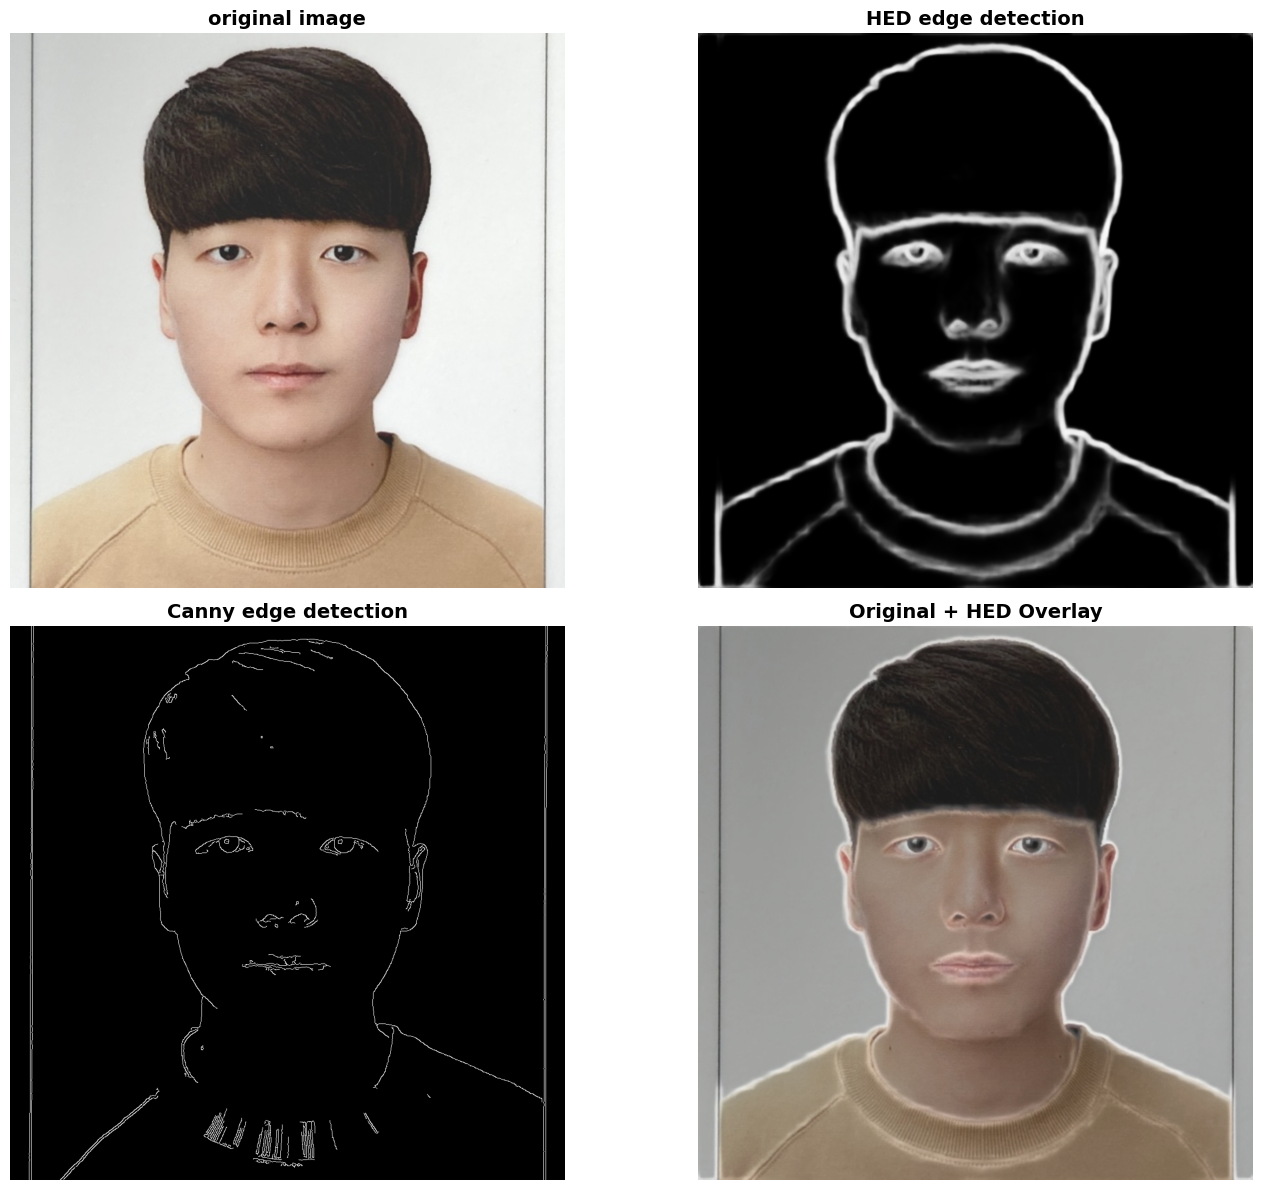

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import urllib.request
import os

# CropLayer 클래스 정의
class CropLayer(object):
    def __init__(self, params, blobs):
        self.xstart = 0
        self.xend = 0
        self.ystart = 0
        self.yend = 0

    def getMemoryShapes(self, inputs):
        inputShape, targetShape = inputs[0], inputs[1]
        batchSize, numChannels = inputShape[0], inputShape[1]
        height, width = targetShape[2], targetShape[3]

        self.ystart = int((inputShape[2] - targetShape[2]) / 2)
        self.xstart = int((inputShape[3] - targetShape[3]) / 2)
        self.yend = self.ystart + height
        self.xend = self.xstart + width

        return [[batchSize, numChannels, height, width]]

    def forward(self, inputs):
        return [inputs[0][:,:,self.ystart:self.yend,self.xstart:self.xend]]

# CropLayer 등록
cv.dnn_registerLayer('Crop', CropLayer)

# 모델 파일 다운로드 함수
def download_hed_model():
    """HED 모델 파일들을 다운로드합니다."""

    # deploy.prototxt 다운로드
    prototxt_url = "https://raw.githubusercontent.com/s9xie/hed/master/examples/hed/deploy.prototxt"
    prototxt_path = "deploy.prototxt"

    if not os.path.exists(prototxt_path):
        print("deploy.prototxt 다운로드 중...")
        urllib.request.urlretrieve(prototxt_url, prototxt_path)
        print("deploy.prototxt 다운로드 완료!")

    # 사전 훈련된 모델 다운로드
    model_url = "https://vcl.ucsd.edu/hed/hed_pretrained_bsds.caffemodel"
    model_path = "hed_pretrained_bsds.caffemodel"

    if not os.path.exists(model_path):
        print("HED 사전 훈련 모델 다운로드 중... (약 56MB)")
        urllib.request.urlretrieve(model_url, model_path)
        print("모델 다운로드 완료!")

    return prototxt_path, model_path

# HED 엣지 검출 함수
def hed_edge_detection(image_path, width=500, height=500):
    """
    HED 모델을 사용하여 엣지 검출을 수행합니다.

    Args:
        image_path: 입력 이미지 경로
        width: 리사이즈할 너비
        height: 리사이즈할 높이

    Returns:
        original_image: 원본 이미지
        edge_map: 엣지 맵
    """

    # 모델 파일 다운로드
    prototxt_path, model_path = download_hed_model()

    # 네트워크 로드
    print("HED 네트워크 로딩 중...")
    net = cv.dnn.readNetFromCaffe(prototxt_path, model_path)
    print("네트워크 로딩 완료!")

    # 이미지 읽기
    image = cv.imread(image_path)
    if image is None:
        raise ValueError("이미지를 읽을 수 없습니다. 경로를 확인해주세요.")

    # 원본 크기 저장
    original_height, original_width = image.shape[:2]

    # 이미지 전처리
    image_resized = cv.resize(image, (width, height))

    # 블롭 생성 (HED 모델에 맞는 전처리)
    blob = cv.dnn.blobFromImage(image_resized,
                               scalefactor=1.0,
                               size=(width, height),
                               mean=(104.00698793, 116.66876762, 122.67891434),
                               swapRB=False,
                               crop=False)

    # 네트워크에 입력 설정
    net.setInput(blob)

    # 순전파 실행
    print("엣지 검출 실행 중...")
    output = net.forward()

    # 출력 후처리
    edge_map = output[0, 0]
    edge_map = cv.resize(edge_map, (original_width, original_height))
    edge_map = (255 * edge_map).astype(np.uint8)

    print("엣지 검출 완료!")

    return image, edge_map

# 결과 시각화
def visualize_results(original_image, edge_map, canny_comparison=True):
    """
    결과를 시각화합니다.

    Args:
        original_image: 원본 이미지
        edge_map: HED 엣지 맵
        canny_comparison: Canny 엣지 검출과 비교할지 여부
    """

    if canny_comparison:
        # Canny 엣지 검출 (비교용)
        gray = cv.cvtColor(original_image, cv.COLOR_BGR2GRAY)
        canny_edges = cv.Canny(gray, 50, 150)

        # 4개 서브플롯으로 비교 시각화
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 원본 이미지 (BGR to RGB 변환)
        axes[0, 0].imshow(cv.cvtColor(original_image, cv.COLOR_BGR2RGB))
        axes[0, 0].set_title('original image', fontsize=14, fontweight='bold')
        axes[0, 0].axis('off')

        # HED 엣지 검출 결과
        axes[0, 1].imshow(edge_map, cmap='gray')
        axes[0, 1].set_title('HED edge detection', fontsize=14, fontweight='bold')
        axes[0, 1].axis('off')

        # Canny 엣지 검출 결과
        axes[1, 0].imshow(canny_edges, cmap='gray')
        axes[1, 0].set_title('Canny edge detection', fontsize=14, fontweight='bold')
        axes[1, 0].axis('off')

        # 원본과 HED 결과 오버레이
        overlay = cv.cvtColor(original_image, cv.COLOR_BGR2RGB).copy()
        overlay_mask = np.stack([edge_map, edge_map, edge_map], axis=-1)
        overlay = cv.addWeighted(overlay, 0.7, overlay_mask, 0.3, 0)

        axes[1, 1].imshow(overlay)
        axes[1, 1].set_title('Original + HED Overlay', fontsize=14, fontweight='bold')
        axes[1, 1].axis('off')

    else:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        axes[0].imshow(cv.cvtColor(original_image, cv.COLOR_BGR2RGB))
        axes[0].set_title('original image', fontsize=14, fontweight='bold')
        axes[0].axis('off')

        axes[1].imshow(edge_map, cmap='gray')
        axes[1].set_title('HED edge detection', fontsize=14, fontweight='bold')
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# 이미지 업로드
def upload_and_process_image():
    """이미지를 업로드하고 HED 엣지 검출을 수행합니다."""

    print("얼굴 이미지를 업로드해주세요:")
    uploaded = files.upload()

    if not uploaded:
        print("이미지가 업로드되지 않았습니다.")
        return

    image_name = list(uploaded.keys())[0]
    print(f"업로드된 이미지: {image_name}")

    try:
        # HED 엣지 검출 실행
        original_image, edge_map = hed_edge_detection(image_name)

        # 결과 시각화
        visualize_results(original_image, edge_map, canny_comparison=True)

    except Exception as e:
        print(f"오류가 발생했습니다: {str(e)}")

if __name__ == "__main__":
    print("=" * 60)
    print("HED (Holistically-Nested Edge Detection) 얼굴 엣지 검출")
    print("=" * 60)
    print()

    # 이미지 업로드 및 처리 실행
    upload_and_process_image()
